In [1]:
import numpy as np # linear algebra
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')
import util
from timeit import default_timer as timer
# set a results file
logger = util.result(path="", file="results.logs")
logger.propagate = False

from sklearn.preprocessing import StandardScaler

<h3 style="color: #dddda1">Pull configs and set defaults</h3>

In [2]:
files = util.get_config_values("files")
validation_types = util.get_config_values("validation_types")
split_types = util.get_config_values("split_types")
split_size = util.get_config_values("split_size")
preprocessors = util.get_config_values("preprocessors")
models = util.get_config_values("models")
evaluators = util.get_config_values("evaluators")
pls_max_n_comp = util.get_config_values("general", list_type=False, key="pls_max_n_comp")
folds = util.get_config_values("general", list_type=False, key="folds")
wl = np.arange(1100, 2252, 2) # Set wavelength range
pipeline_run_types = util.get_config_values("pipeline_run_types")

<h3 style="color: #eeaf23">Data Import, Split and Visualization</h3>

Shape of the dataset : (80, 577)
Dataset overview : 

          y  xtrain.1  xtrain.2  xtrain.3  xtrain.4  xtrain.5  xtrain.6  \
0  4.230000  0.245288  0.251593  0.258437  0.265449  0.272342  0.280249   
1  6.020000  0.242613  0.248841  0.255609  0.262486  0.269311  0.277092   
2  6.490000  0.241651  0.247774  0.254431  0.261214  0.267891  0.275535   
3  8.920000  0.239650  0.245743  0.252350  0.259107  0.265761  0.273390   
4  8.979999  0.240787  0.246900  0.253521  0.260278  0.266935  0.274576   

   xtrain.7  xtrain.8  xtrain.9  ...  xtrain.567  xtrain.568  xtrain.569  \
0  0.288323  0.297118  0.307861  ...    3.679895    3.654557    3.653983   
1  0.285063  0.293715  0.304371  ...    3.632740    3.738945    3.601677   
2  0.283370  0.291886  0.302335  ...    3.563812    3.622122    3.617598   
3  0.281214  0.289725  0.300164  ...    3.583575    3.620621    3.682378   
4  0.282420  0.290953  0.301394  ...    3.650906    3.728940    3.614735   

   xtrain.570  xtrain.571  xtrain.572 

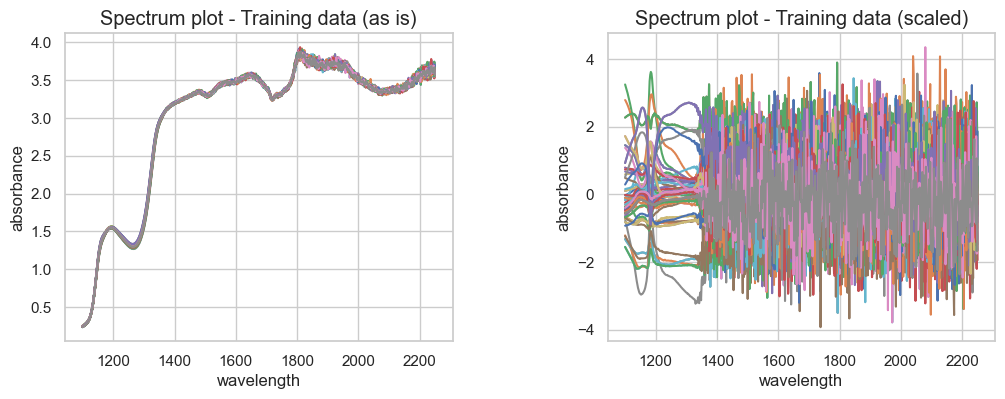

In [3]:
# for only one file - write dataset = files[index] (index maybe 0-3).
# For multiple files set value as list. e.g. - [files[0],files[2]]
# for all files, set dataset = files
dataset = files[1]   # using the beer dataset

# Nothing to change here.
split_params = {
    'sep' : ',',
    'drop_columns' : ['y'],
    'index_column' : None,
    'y_data_column' : 'y',
}

# Data splitting can be done in various proportions. Check proportions of train-test values available in configfile.ini file
data = (X_train, X_test, y_train, y_test) = util.get_split_data(files=dataset, split_params=split_params, test_size=float(split_size[0]), showDataEDA=True)

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# plot training spectrum as is
# util.plot(x_axis_data=wl, y_axis_data=X_train, title='Spectrum plot - Training data (as is)', xlabel='wavelength',
#      ylabel='absorbance')

#
# util.plot(x_axis_data=wl, y_axis_data=X_train_scaled, title='Spectrum plot - Training data (scaled)', xlabel='wavelength',
#      ylabel='absorbance')

plot1_params = {
    'x_axis_data' : wl,
    'y_axis_data': X_train,
    'title':'Spectrum plot - Training data (as is)',
    'xlabel':'wavelength',
    'ylabel':'absorbance'
}
plot2_params = {
    'x_axis_data' : wl,
    'y_axis_data': X_train_scaled,
    'title':'Spectrum plot - Training data (scaled)',
    'xlabel':'wavelength',
    'ylabel':'absorbance'
}
util.dual_plot(plot1_params,plot2_params)

<h3 style="color: #eeaf23">Pre-processor 1 (Scaling + Derivative)</h3>

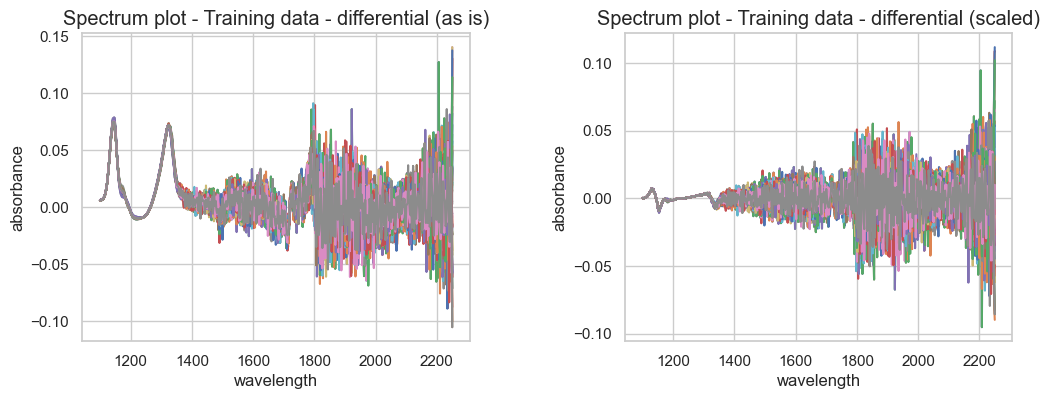

In [4]:
X_train_diff = np.gradient(X_train, axis=1)
X_train_diff_scaled = np.gradient(X_train_diff, axis=1)

plot1_params = {
    'x_axis_data' : wl,
    'y_axis_data': X_train_diff,
    'title':'Spectrum plot - Training data - derivative (as is)',
    'xlabel':'wavelength',
    'ylabel':'absorbance'
}
plot2_params = {
    'x_axis_data' : wl,
    'y_axis_data': X_train_diff_scaled,
    'title':'Spectrum plot - Training data - derivative (scaled)',
    'xlabel':'wavelength',
    'ylabel':'absorbance'
}
util.dual_plot(plot1_params,plot2_params)

<h3 style="color: #eeaf23">Pre-processor 2 (Derivative 0,1,2 + Smoothing)</h3>

<h5 style="color: #99aa23">All Derivatives + Smoothing (with different split sizes)</h5>

In [6]:
# SAVGOL + Deriv 0, 1, 2 with split sizes (85:15, 75:25, 60:40 and 50:50)

for i in range(0,3):
    window_range = np.arange(3,63,3)
    polyorder_range = np.arange(2,18,2)
    derivative = i

    for j in range(0,4):
        if(j==0):
            size =float(split_size[0])
        elif(j==1):
            size =float(split_size[2])
        elif(j==2):
            size =float(split_size[4])
        else:
            size =float(split_size[5])
        # Splitting the data as per split size
        data = (X_train, X_test, y_train, y_test) = util.get_split_data(files=dataset, split_params=split_params, test_size=size, showDataEDA=False)
        X_train_preprocessed, X_test_preprocessed, least_mse_score, best_window_size, best_polyorder = \
            util.savgol(data, window_size_range=window_range,
                   polyorder_range=polyorder_range,
                   deriv=derivative, showPlot=False)

        # PRINT LEAST MSE_SCORE VALUE, BEST WINDOW_SIZE AND BEST POLYNOMIAL
        print("Derivative {} and Split Size (test) {}".format(derivative, size))
        print("Least MSE from SAVGOL loop run {}".format(least_mse_score))
        print("Best window size {}".format(best_window_size))
        print("Best polyorder {}".format(best_polyorder))

Derivative 0 and Split Size (test) 0.15
Least MSE from SAVGOL loop run 0.1332871929789876
Best window size 15
Best polyorder 14
Derivative 0 and Split Size (test) 0.25
Least MSE from SAVGOL loop run 0.13162111573424773
Best window size 15
Best polyorder 14
Derivative 0 and Split Size (test) 0.4
Least MSE from SAVGOL loop run 0.08865336917064691
Best window size 9
Best polyorder 8
Derivative 0 and Split Size (test) 0.5
Least MSE from SAVGOL loop run 0.07442324630508193
Best window size 9
Best polyorder 8
Derivative 1 and Split Size (test) 0.15
Least MSE from SAVGOL loop run 0.010307627376843195
Best window size 3
Best polyorder 2
Derivative 1 and Split Size (test) 0.25
Least MSE from SAVGOL loop run 0.006600385040642968
Best window size 18
Best polyorder 14
Derivative 1 and Split Size (test) 0.4
Least MSE from SAVGOL loop run 0.0062473713260009665
Best window size 6
Best polyorder 4
Derivative 1 and Split Size (test) 0.5
Least MSE from SAVGOL loop run 0.006722911844752613
Best window si

<h5 style="color: #99aa23">Individual Derivative and SavGol combos</h5>

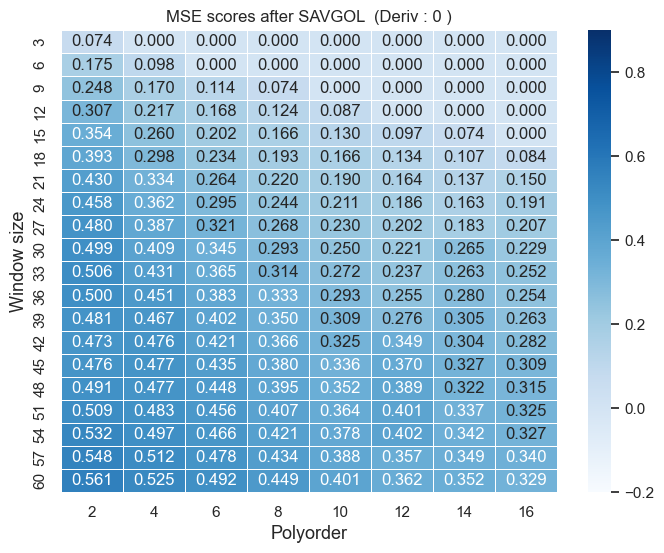

Least MSE from SAVGOL loop run 0.07442324630508193
Best window size 9
Best polyorder 8


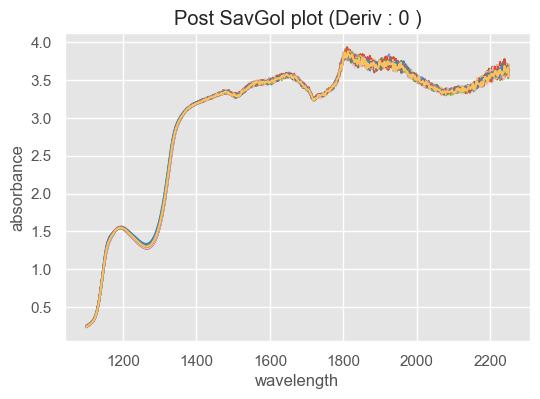

In [7]:
# SAVGOL + Deriv 0

window_range = np.arange(3,63,3)
polyorder_range = np.arange(2,18,2)
derivative = 0

X_train_preprocessed, X_test_preprocessed, least_mse_score, best_window_size, best_polyorder = \
    util.savgol(data, window_size_range=window_range,
           polyorder_range=polyorder_range,
           deriv=derivative, showPlot=True)

# PRINT LEAST MSE_SCORE VALUE, BEST WINDOW_SIZE AND BEST POLYNOMIAL
print("Least MSE from SAVGOL loop run {}".format(least_mse_score))
print("Best window size {}".format(best_window_size))
print("Best polyorder {}".format(best_polyorder))

util.plot(x_axis_data=wl, y_axis_data=X_train_preprocessed,
     title='Post SavGol plot (Deriv : ' + str(derivative) + ' )', xlabel='wavelength',
     ylabel='absorbance')

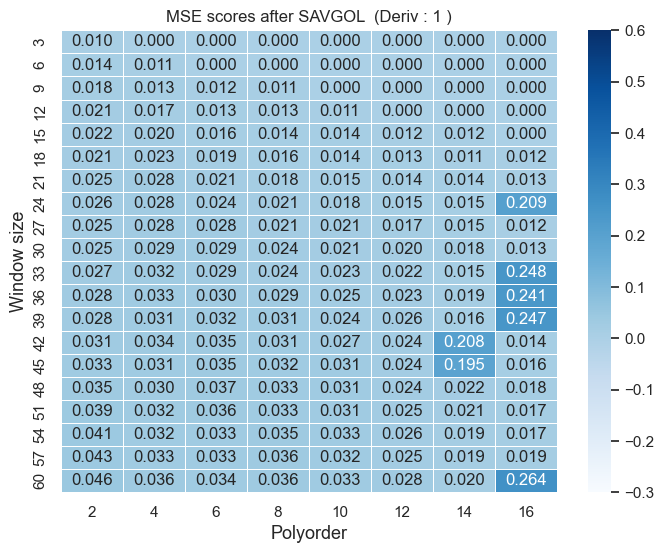

Least MSE from SAVGOL loop run 0.010307627376843195
Best window size 3
Best polyorder 2


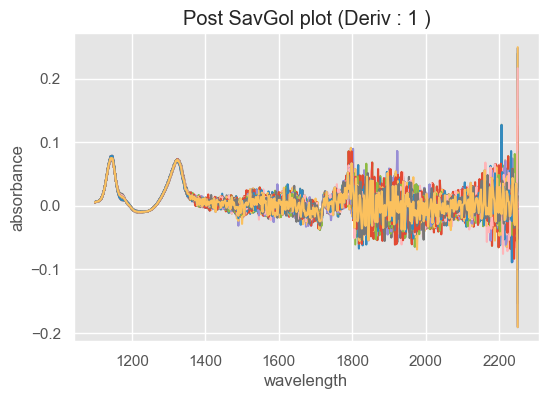

In [6]:
# SAVGOL + Deriv 1

window_range = np.arange(3,63,3)
polyorder_range = np.arange(2,18,2)
derivative = 1

X_train_preprocessed, X_test_preprocessed, least_mse_score, best_window_size, best_polyorder = \
    util.savgol(data, window_size_range=window_range,
           polyorder_range=polyorder_range,
           deriv=derivative, showPlot=True)

# PRINT LEAST MSE_SCORE VALUE, BEST WINDOW_SIZE AND BEST POLYNOMIAL
print("Least MSE from SAVGOL loop run {}".format(least_mse_score))
print("Best window size {}".format(best_window_size))
print("Best polyorder {}".format(best_polyorder))

util.plot(x_axis_data=wl, y_axis_data=X_train_preprocessed,
     title='Post SavGol plot (Deriv : ' + str(derivative) + ' )', xlabel='wavelength',
     ylabel='absorbance')

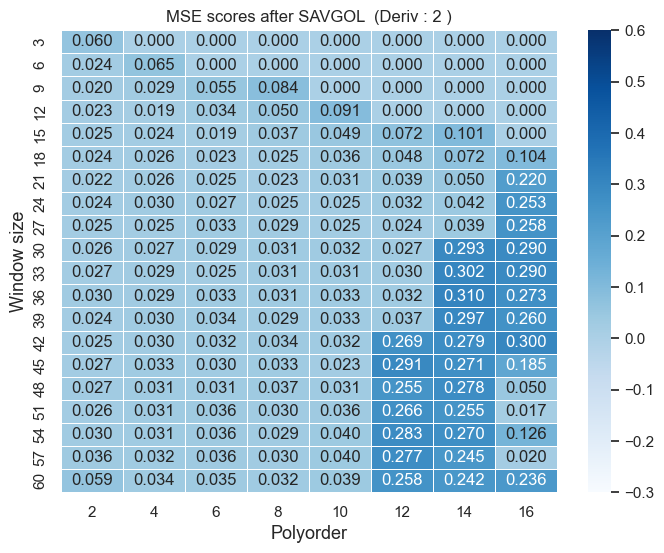

Least MSE from SAVGOL loop run 0.017015383983733937
Best window size 51
Best polyorder 16


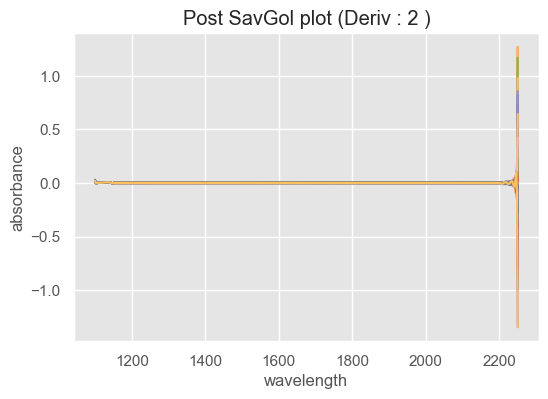

In [7]:
# SAVGOL + Deriv 2

window_range = np.arange(3,63,3)
polyorder_range = np.arange(2,18,2)
derivative = 2

X_train_preprocessed, X_test_preprocessed, least_mse_score, best_window_size, best_polyorder = \
    util.savgol(data, window_size_range=window_range,
           polyorder_range=polyorder_range,
           deriv=derivative, showPlot=True)

# PRINT LEAST MSE_SCORE VALUE, BEST WINDOW_SIZE AND BEST POLYNOMIAL
print("Least MSE from SAVGOL loop run {}".format(least_mse_score))
print("Best window size {}".format(best_window_size))
print("Best polyorder {}".format(best_polyorder))

util.plot(x_axis_data=wl, y_axis_data=X_train_preprocessed,
     title='Post SavGol plot (Deriv : ' + str(derivative) + ' )', xlabel='wavelength',
     ylabel='absorbance')

<h3 style="color: #eeaf23">Pre-processor 3 (Scatter Correction)</h3>

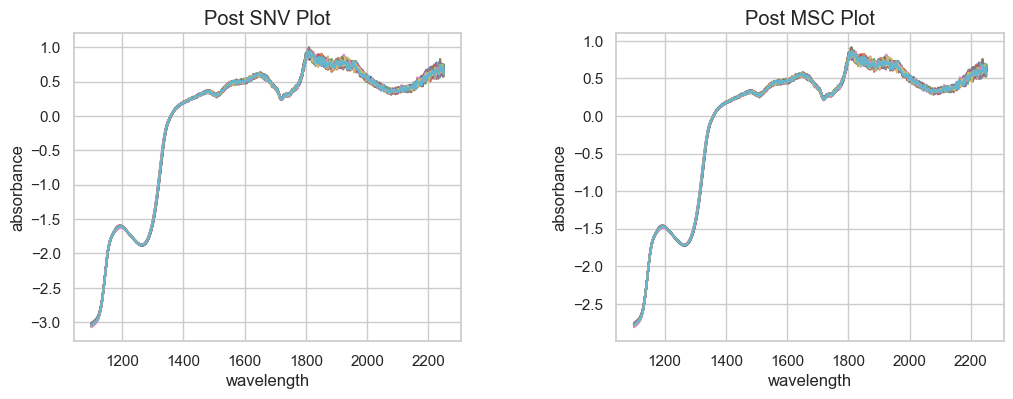

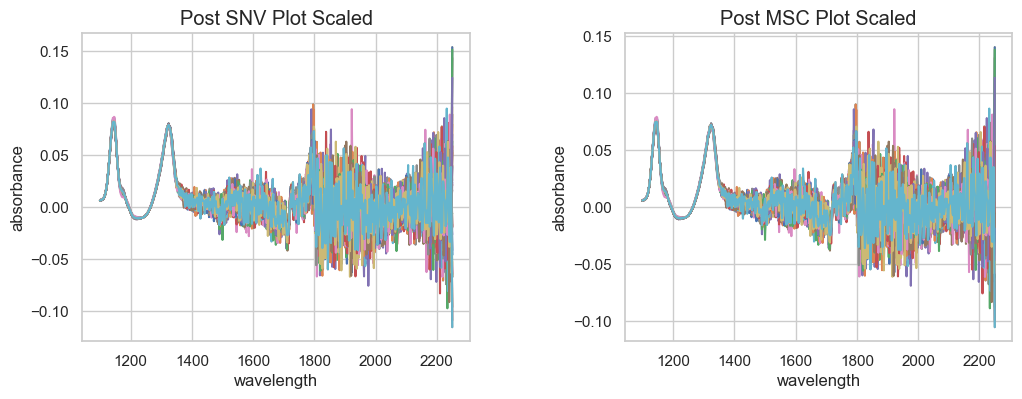

In [8]:
# SNV
X_train_snv, X_test_snv = util.snv(data)
X_train_snv_scaled = np.gradient(X_train_snv, axis=1)

# MSC
X_train_msc, X_test_msc = util.msc(data)
X_train_msc_scaled = np.gradient(X_train_msc, axis=1)

# Plot for both
plot1_params = {
    'x_axis_data' : wl,
    'y_axis_data': X_train_snv,
    'title':'Post SNV Plot',
    'xlabel':'wavelength',
    'ylabel':'absorbance'
}
plot2_params = {
    'x_axis_data' : wl,
    'y_axis_data': X_train_msc,
    'title':'Post MSC Plot',
    'xlabel':'wavelength',
    'ylabel':'absorbance'
}
util.dual_plot(plot1_params,plot2_params)

# Plot for both scaled
plot3_params = {
    'x_axis_data' : wl,
    'y_axis_data': X_train_snv_scaled,
    'title':'Post SNV Plot Scaled',
    'xlabel':'wavelength',
    'ylabel':'absorbance'
}
plot4_params = {
    'x_axis_data' : wl,
    'y_axis_data': X_train_msc_scaled,
    'title':'Post MSC Plot Scaled',
    'xlabel':'wavelength',
    'ylabel':'absorbance'
}
util.dual_plot(plot3_params,plot4_params)

<h3 style="color: #eeaf23">Pre-processor 4 (Smoothing + Scatter Correction [SNV])</h3>

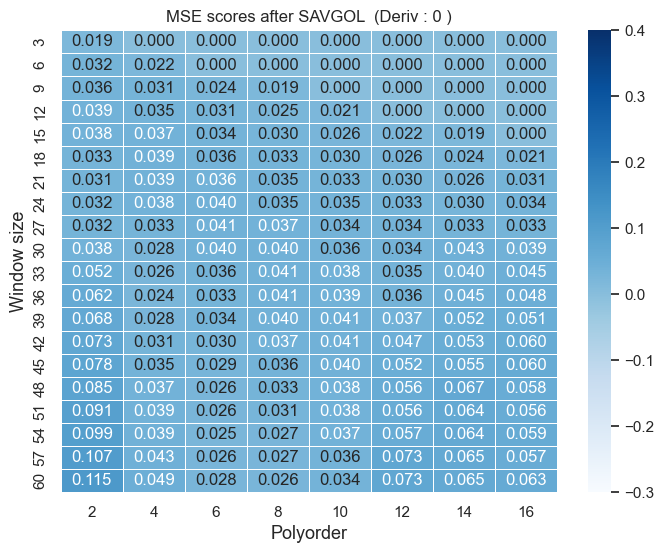

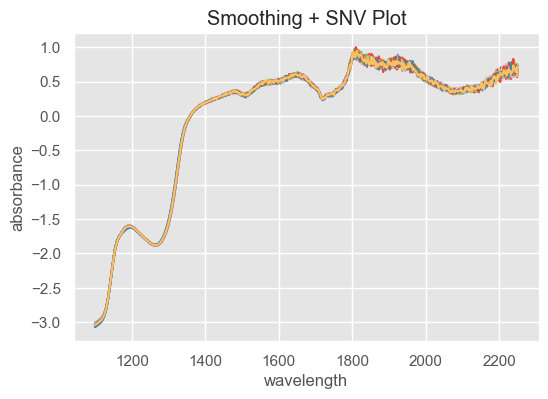

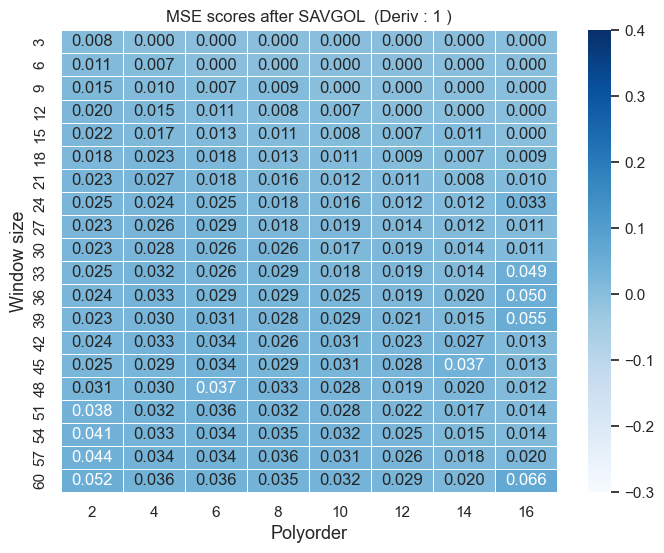

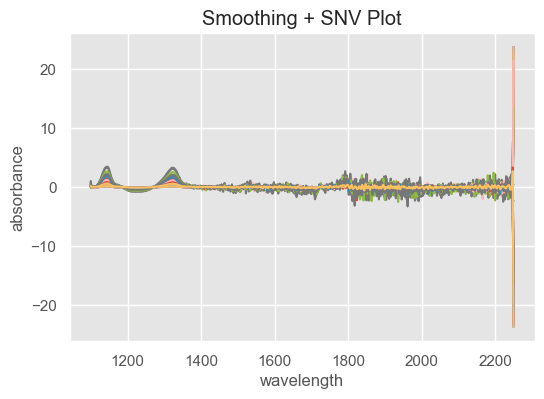

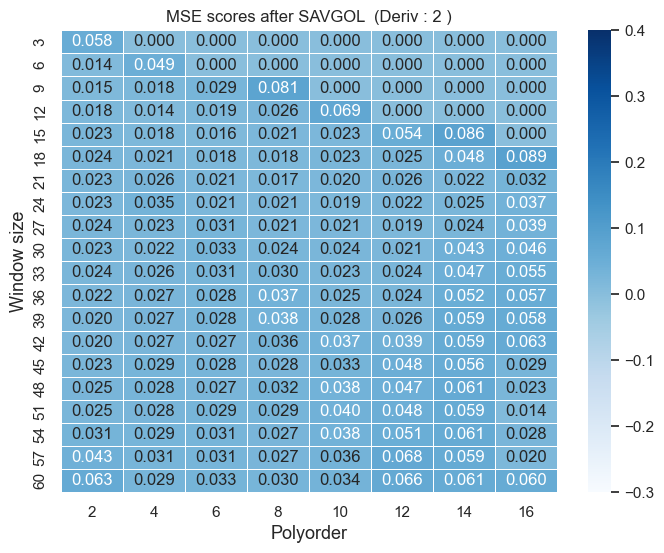

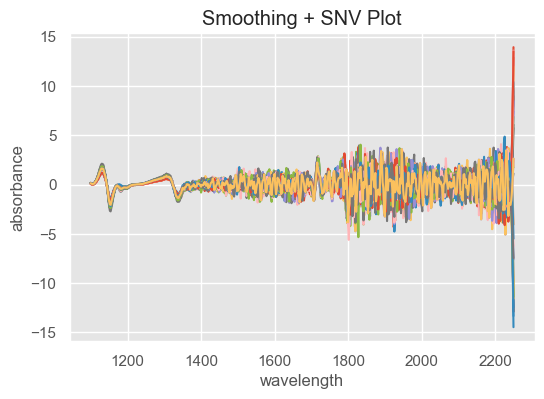

In [9]:
for val in range(0,3):
    window_range = np.arange(3,63,3)
    polyorder_range = np.arange(2,18,2)
    derivative = val

    X_train_smoothed, X_test_smoothed, least_mse_score, best_window_size, best_polyorder = \
        util.savgol(data, window_size_range=window_range,
               polyorder_range=polyorder_range,
               deriv=derivative, showPlot=True)
    data_smoothed = X_train_smoothed, X_test_smoothed, y_train, y_test
    X_train_snv, X_test_snv = util.snv(data_smoothed, afterSmoothing=True)

    util.plot(x_axis_data=wl, y_axis_data=X_train_snv, title='Smoothing + SNV Plot', xlabel='wavelength',
         ylabel='absorbance')

<h3 style="color: #77ff90">Comparing pre-processing performance (with PLS as model for testing)</h3>

R-squared score of unprocessed data: 0.9275268643757713
Mean Squared Error of unprocessed data: 0.3177208294636749
Mean Absolute Error of unprocessed data: 0.3747624250698387
R-squared score of unprocessed data with scaling: 0.7845578551401444
Mean Squared Error of unprocessed data with Scaling: 0.9444942098437726
Mean Absolute Error of unprocessed data with Scaling: 0.893459476574839
R-squared score with differential: 0.9873531634519042
Mean Squared Error with differential: 0.055443487625354
Mean Absolute Error with differential: 0.19194922861219524
R-squared score with differential + scaling: 0.8653551407567905
Mean Squared Error with differential + scaling: 0.5902804672835281
Mean Absolute Error with differential + scaling: 0.7172547877450982


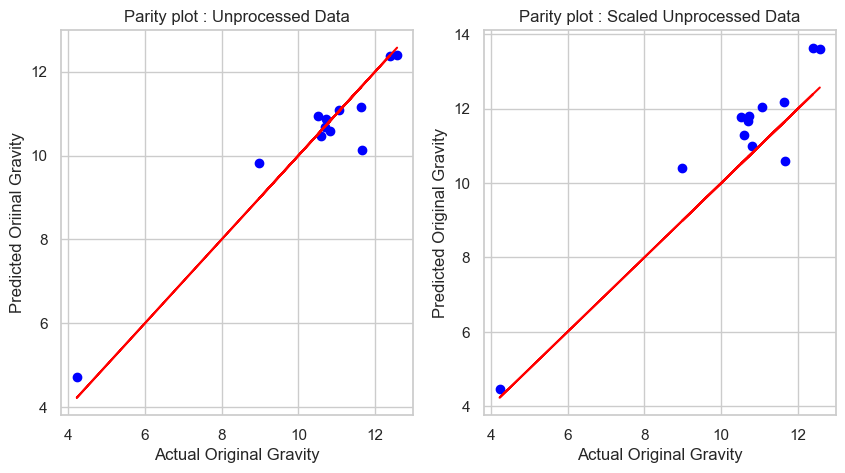

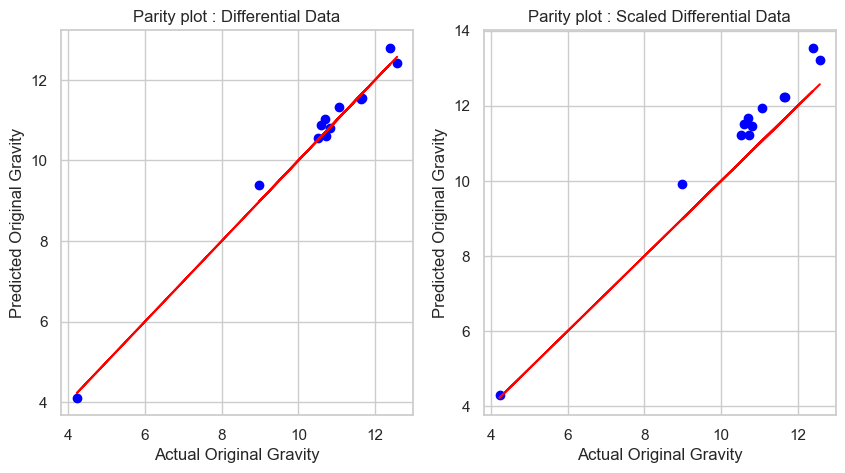

In [4]:
# Setting up the data with preprocessors
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
X_train_diff = np.gradient(X_train, axis=1)
X_test_diff = np.gradient(X_test, axis=1)
X_train_diff_scaled = scaler.fit_transform(X_train_diff)
X_test_diff_scaled = scaler.fit_transform(X_test_diff)


from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Fitting the PLS model with unprocessed data
pls = PLSRegression(n_components=2)
pls.fit(X_train, y_train)
# Predicting the test set results
y_pred = pls.predict(X_test)

# Fitting the PLS model with scaled data
pls = PLSRegression(n_components=2)
pls.fit(X_train_scaled, y_train)
# Predicting the test set results
y_pred_scaled = pls.predict(X_test_scaled)

# Fitting the PLS model with differential data
pls = PLSRegression(n_components=2)
pls.fit(X_train_diff, y_train)
# Predicting the test set results
y_pred_diff = pls.predict(X_test_diff)

# Fitting the PLS model with differential scaled data
pls = PLSRegression(n_components=2)
pls.fit(X_train_diff_scaled, y_train)
# Predicting the test set results
y_pred_diff_scaled = pls.predict(X_test_diff_scaled)

# Calculating the R-squared score
r2 = r2_score(y_test, y_pred)
r2_scaled = r2_score(y_test, y_pred_scaled)
r2_diff = r2_score(y_test, y_pred_diff)
r2_diff_scaled = r2_score(y_test, y_pred_diff_scaled)

mse = mean_squared_error(y_test, y_pred)
mse_scaled = mean_squared_error(y_test, y_pred_scaled)
mse_diff = mean_squared_error(y_test, y_pred_diff)
mse_diff_scaled = mean_squared_error(y_test, y_pred_diff_scaled)

mae = mean_absolute_error(y_test, y_pred)
mae_scaled = mean_absolute_error(y_test, y_pred_scaled)
mae_diff = mean_absolute_error(y_test, y_pred_diff)
mae_diff_scaled = mean_absolute_error(y_test, y_pred_diff_scaled)

print('R-squared score of unprocessed data:', r2)
print('Mean Squared Error of unprocessed data:', mse)
print('Mean Absolute Error of unprocessed data:', mae)

print('R-squared score of unprocessed data with scaling:', r2_scaled)
print('Mean Squared Error of unprocessed data with Scaling:', mse_scaled)
print('Mean Absolute Error of unprocessed data with Scaling:', mae_scaled)

print('R-squared score with differential:', r2_diff)
print('Mean Squared Error with differential:', mse_diff)
print('Mean Absolute Error with differential:', mae_diff)

print('R-squared score with differential + scaling:', r2_diff_scaled)
print('Mean Squared Error with differential + scaling:', mse_diff_scaled)
print('Mean Absolute Error with differential + scaling:', mae_diff_scaled)


import matplotlib.pyplot as plt
fig4 = plt.figure(figsize=(10, 5))

# Plot spectra as is
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, color='blue')
plt.plot(y_test, y_test, color='red')
plt.title('Parity plot : Unprocessed Data')
plt.xlabel('Actual Original Gravity')
plt.ylabel('Predicted Oriinal Gravity')
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_scaled, color='blue')
plt.plot(y_test, y_test, color='red')
plt.title('Parity plot : Scaled Unprocessed Data')
plt.xlabel('Actual Original Gravity')
plt.ylabel('Predicted Original Gravity')
plt.show()

fig5 = plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_diff, color='blue')
plt.plot(y_test, y_test, color='red')
plt.title('Parity plot : Differential Data')
plt.xlabel('Actual Original Gravity')
plt.ylabel('Predicted Original Gravity')
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_diff_scaled, color='blue')
plt.plot(y_test, y_test, color='red')
plt.title('Parity plot : Scaled Differential Data')
plt.xlabel('Actual Original Gravity')
plt.ylabel('Predicted Original Gravity')
plt.show()

R-squared score with SavGol smoothing: 0.9873737219797477
Mean Squared Error with SavGol smoothing: 0.05535335943560845
Mean Absolute Error with SavGol smoothing: 0.19157381667134818
R-squared score with SavGol smoothing + Scaled: 0.8654690701207814
Mean Squared Error with SavGol smoothing + Scaled: 0.5897810031480847
Mean Absolute Error with SavGol smoothing + Scaled: 0.7172547877450821
R-squared score with scatter correction: 0.993409909437432
Mean Squared Error with scatter correction: 0.02889082998472969
Mean Absolute Error with scatter correction: 0.15270301245304263
R-squared score with scatter correction + Scaled: 0.8701544471037116
Mean Squared Error with scatter correction + Scaled: 0.5692404007780539
Mean Absolute Error with scatter correction + Scaled: 0.7172547877450919


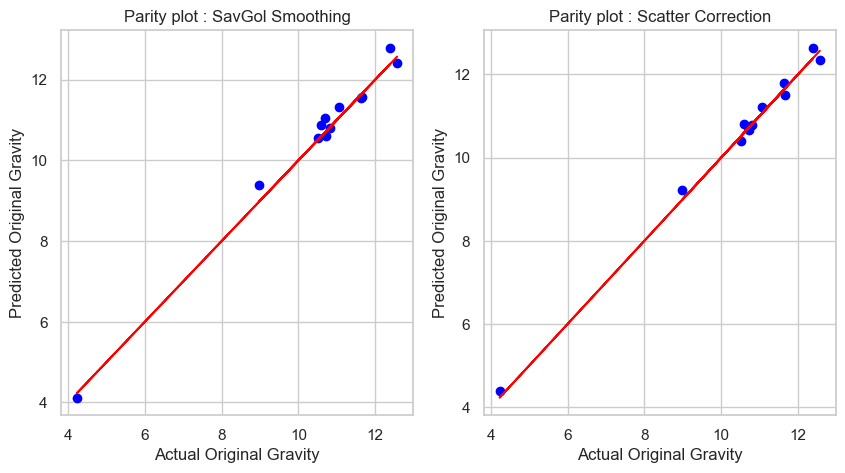

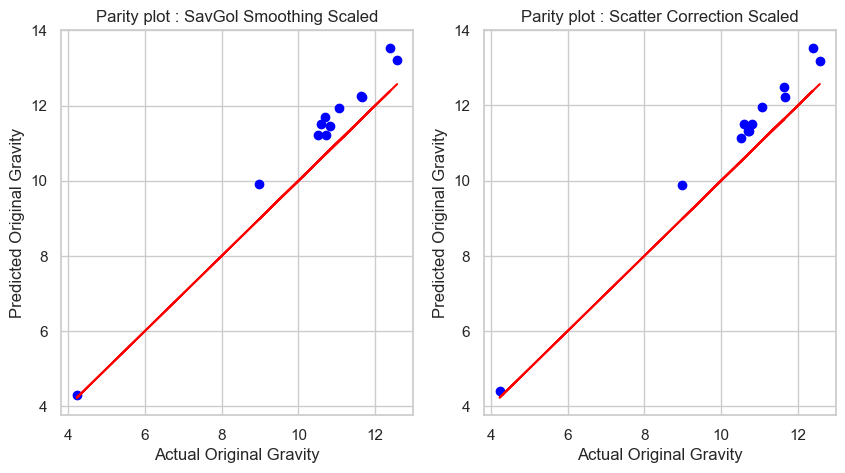

In [5]:
# Setting up the data with preprocessors

window_range = np.arange(3,63,3)
polyorder_range = np.arange(2,18,2)
derivative = 1

X_train_smoothed, X_test_smoothed, least_mse_score, best_window_size, best_polyorder = \
    util.savgol(data, window_size_range=window_range,
           polyorder_range=polyorder_range,
           deriv=derivative, showPlot=False)

# SNV from scattering techniques
X_train_snv, X_test_snv = util.snv(data)

# Scaling the SavGol and SNV results
X_train_smoothed_scaled = scaler.fit_transform(X_train_smoothed)
X_test_smoothed_scaled = scaler.fit_transform(X_test_smoothed)
X_train_snv_scaled = scaler.fit_transform(X_train_snv)
X_test_snv_scaled = scaler.fit_transform(X_test_snv)

from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Fitting the PLS model with smoothed data
pls = PLSRegression(n_components=2)
pls.fit(X_train_smoothed, y_train)
# Predicting the test set results
y_pred_smoothed = pls.predict(X_test_smoothed)

# Fitting the PLS model with smoothed and scaled data
pls = PLSRegression(n_components=2)
pls.fit(X_train_smoothed_scaled, y_train)
# Predicting the test set results
y_pred_smoothed_scaled = pls.predict(X_test_smoothed_scaled)

# Fitting the PLS model with scatter correction data
pls = PLSRegression(n_components=2)
pls.fit(X_train_snv, y_train)
# Predicting the test set results
y_pred_snv = pls.predict(X_test_snv)

# Fitting the PLS model with scatter correction and scaled data
pls = PLSRegression(n_components=2)
pls.fit(X_train_snv_scaled, y_train)
# Predicting the test set results
y_pred_snv_scaled = pls.predict(X_test_snv_scaled)

# Calculating the R-squared score
r2_smoothed = r2_score(y_test, y_pred_smoothed)
r2_smoothed_scaled = r2_score(y_test, y_pred_smoothed_scaled)
r2_snv = r2_score(y_test, y_pred_snv)
r2_snv_scaled = r2_score(y_test, y_pred_snv_scaled)

mse_smoothed = mean_squared_error(y_test, y_pred_smoothed)
mse_smoothed_scaled = mean_squared_error(y_test, y_pred_smoothed_scaled)
mse_snv = mean_squared_error(y_test, y_pred_snv)
mse_snv_scaled = mean_squared_error(y_test, y_pred_snv_scaled)

mae_smoothed = mean_absolute_error(y_test, y_pred_smoothed)
mae_smoothed_scaled = mean_absolute_error(y_test, y_pred_smoothed_scaled)
mae_snv = mean_absolute_error(y_test, y_pred_snv)
mae_snv_scaled = mean_absolute_error(y_test, y_pred_snv_scaled)

print('R-squared score with SavGol smoothing:', r2_smoothed)
print('Mean Squared Error with SavGol smoothing:', mse_smoothed)
print('Mean Absolute Error with SavGol smoothing:', mae_smoothed)

print('R-squared score with SavGol smoothing + Scaled:', r2_smoothed_scaled)
print('Mean Squared Error with SavGol smoothing + Scaled:', mse_smoothed_scaled)
print('Mean Absolute Error with SavGol smoothing + Scaled:', mae_smoothed_scaled)

print('R-squared score with scatter correction:', r2_snv)
print('Mean Squared Error with scatter correction:', mse_snv)
print('Mean Absolute Error with scatter correction:', mae_snv)

print('R-squared score with scatter correction + Scaled:', r2_snv_scaled)
print('Mean Squared Error with scatter correction + Scaled:', mse_snv_scaled)
print('Mean Absolute Error with scatter correction + Scaled:', mae_snv_scaled)


import matplotlib.pyplot as plt
fig6 = plt.figure(figsize=(10, 5))

# Plot spectra as is
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_smoothed, color='blue')
plt.plot(y_test, y_test, color='red')
plt.title('Parity plot : SavGol Smoothing')
plt.xlabel('Actual Original Gravity')
plt.ylabel('Predicted Original Gravity')
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_snv, color='blue')
plt.plot(y_test, y_test, color='red')
plt.title('Parity plot : Scatter Correction')
plt.xlabel('Actual Original Gravity')
plt.ylabel('Predicted Original Gravity')
plt.show()

fig7 = plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_smoothed_scaled, color='blue')
plt.plot(y_test, y_test, color='red')
plt.title('Parity plot : SavGol Smoothing Scaled')
plt.xlabel('Actual Original Gravity')
plt.ylabel('Predicted Original Gravity')
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_snv_scaled, color='blue')
plt.plot(y_test, y_test, color='red')
plt.title('Parity plot : Scatter Correction Scaled')
plt.xlabel('Actual Original Gravity')
plt.ylabel('Predicted Original Gravity')
plt.show()